# Video Preprocessing

Description

In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
import os
import glob
import cv2
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json

In [93]:
from video_analyzer import VideoAnalyzer, get_processing_params
from preprocessor import Preprocessor

In [94]:
timestamp = "04042025"
motion_version = "versionA"
pose_version = "versionA"
path_to_root = "/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/"

In [95]:
metadata = pd.read_csv(os.path.join(
    path_to_root,
    "data",
    "raw",
    "combined",
    "target_dataset_video_metadata.csv"
    ))

In [96]:
i = 1
metadata_row = metadata.iloc[i].copy()
metadata_row

filename        ajudar_sb_2.mp4
label                    ajudar
data_source                  sb
frame_count                  79
fps                    29.97003
duration_sec           2.635967
width                      1280
height                      720
Name: 1, dtype: object

## Initialize VideoAnalyzer

The VideoAnalyzer has default parameters, but individual parameters can be overridden by passing a params_dict to the constructor.

In [97]:
params = {}
params["motion_start_threshold"] = 0.2
# params["verbose"] =False
params["reuse_results"] = True

You can also override the default parameters by having a column in the metadata_row with the same name as the parameter you want to override.

In [98]:
metadata_row.loc['motion_end_threshold'] = 0.3

The priority order is:
1. params_dict
2. metadata_row
3. default parameters

When you call the constructor, it will tell you which parameters are used and from where.

In [99]:
analyzer = VideoAnalyzer(
    metadata_row,
    timestamp,
    path_to_root,
    params,
    verbose=False,
    motion_detection_version=motion_version,
    pose_detection_version=pose_version
)

## Motion Detection

`.motion_detect()` will:
- apply all the motion detection methods specified in the code
- save the raw results in /data/interim/RawMotionMeasurements/version{version}/{filename}_{detection_method}.npy
- (or load the already detected raw results to save reprocessing time if reuse_results is True)
- normalize the raw results to a 0-1 scale and combine them as a weighted average
- apply a moving average to the combined results to smooth the data
- return a dictionary with the derived results

In [100]:
motion_data = analyzer.motion_detect()

window_duration: 0.2 seconds, at 29.97002997002997 fps = 5 frame window_size


`.motion_analyze()` will:
- analyze the motion data to find the start and end frames of meaningful motion
- it requires the motion_data to be loaded/created, and some parameters that are used for the method to decide the start and end frames
- it will return a dictionary with the derived start and end frames, and some other related information

In [101]:
motion_result = analyzer.motion_analyze()

## Pose Estimation

`.pose_detect()` will:
- apply the MediaPipe Holistic model (with some specified parameters) to the video to detect Face, Pose, and Hand Landmarks
- save the raw results in /data/interim/RawPoseLandmarks/version{version}/{filename}.npy
- (or load the already detected raw results to save reprocessing time if reuse_results is True)
- return a dictionary with the derived results


In [102]:
pose_data = analyzer.pose_detect()

Loaded pose estimation results from versionA


`.pose_analyze()` will:
- analyze the loaded/created pose data using various methods from `media_pipe_holistic.py`
- currently this includes:
    - horizontal and vertical positions of various key landmarks
    - various measurements between landmarks
- it will return a dictionary with the results


In [103]:
pose_result = analyzer.pose_analyze()

W0000 00:00:1743858175.084031   66630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743858175.209251   66632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743858175.213697   66630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743858175.213705   66628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743858175.218188   66631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743858175.223275   66630 inference_feedback_manager.cc:114] Feedback manager 

## Save Analysis Info

`.save_analysis_info()` will:
- save all of the analysis info and other metadata to a json file in /data/interim/AnalysisInfo/version{version}/{filename}.json
- it will return a dictionary with the analysis info
- currently this includes:
    - the metadata about the video that was used
    - the parameters used in the detection and analysis
    - the results from the motion detection result analysis
    - the results from the pose detection result analysis


In [104]:
analysis_info = analyzer.save_analysis_info()

## Get/Make Preprocessing Params for `preprocessor`

Preprocessor requires:
- start_frame 
- end_frame 
- horizontal_offset 
- x_scale_factor 
- y_scale_factor
- vertical_offset 
- target_duration

In [105]:
path_to_root

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/'

In [106]:
analysis_info = json.load(open(os.path.join(path_to_root, "data", "interim", "Analysis", f"{timestamp}_motion{motion_version}_pose{pose_version}", metadata_row["filename"].split(".")[0] + "_analysis_info.json")))

### Set Reference Values
- These were decided based on EDA of the full dataset's analysis info in `Analyzed_Videos_EDA.ipynb`.
- They can be changed in future versions if we want to use different reference values to produce different results.

In [107]:
reference_values = {
'face_horizontal_offset': 0.5,
'face_vertical_offset': 0.275,
'face_width': 0.11,
'face_height': 0.23,
'shoulders_horizontal_offset': 0.5,
'shoulders_vertical_offset': 0.52,
'shoulders_width': 0.25,
}

### Start Frame / End Frame

In [108]:
start_frame = analysis_info["motion_analysis"]["start_frame"]
end_frame = analysis_info["motion_analysis"]["end_frame"]

### Horizontal Offset

Based on the analysis in `Analyzed_Videos_EDA.ipynb`, we are currently using the median horizontal offset for the shoulders and face.

In [109]:
shoulders_median = analysis_info["pose_analysis"]["horizontal_offsets"]["shoulders"]["median"]
face_median = analysis_info["pose_analysis"]["horizontal_offsets"]["face"]["median"]

shoulders_reference = 0.5 # (because we want the signer to be horizontally centered)
face_reference = 0.5 # (because we want the signer to be horizontally centered)

shoulders_offset = shoulders_reference - shoulders_median
face_offset = face_reference - face_median

shoulders_weight = 0.7 # (arbitrarily chosen, because I assume shoulders move less than the face)
face_weight = 0.3 # (arbitrarily chosen, because I assume shoulders move less than the face)
horizontal_offset = shoulders_weight * shoulders_offset + face_weight * face_offset
horizontal_offset

0.0034888207912445067

### X Scale Factor, Y Scale Factor

In [110]:
reference_values

{'face_horizontal_offset': 0.5,
 'face_vertical_offset': 0.275,
 'face_width': 0.11,
 'face_height': 0.23,
 'shoulders_horizontal_offset': 0.5,
 'shoulders_vertical_offset': 0.52,
 'shoulders_width': 0.25}

In [111]:
# Measurements from the video
## Horizontal
shoulder_width = analysis_info["pose_analysis"]["landmark_measurements"]["shoulder_width"]["mean"]
face_width = analysis_info["pose_analysis"]["landmark_measurements"]["face_width"]["mean"]
## Vertical
face_height = analysis_info["pose_analysis"]["landmark_measurements"]["face_height"]["mean"]
shoulders_to_bottom = 1 - analysis_info["pose_analysis"]["vertical_offsets"]["shoulders"]["median"]

# Reference values to scale to
## Horizontal
reference_shoulder_width = reference_values["shoulders_width"]
reference_face_width = reference_values["face_width"]
## Vertical
reference_face_height = reference_values["face_height"]
reference_shoulders_to_bottom = 1 - reference_values["shoulders_vertical_offset"]

# Scale Factors
## Horizontal
shoulder_width_weight = 0.7
face_width_weight = 0.3
x_scale_factor = shoulder_width_weight * reference_shoulder_width / shoulder_width + face_width_weight * reference_face_width / face_width
## Vertical
face_height_weight = 0.7
shoulders_to_bottom_weight = 0.3
y_scale_factor = face_height_weight * reference_face_height / face_height + shoulders_to_bottom_weight * reference_shoulders_to_bottom / shoulders_to_bottom

x_scale_factor, y_scale_factor

(1.254403200242209, 1.168761328924501)

### Vertical Offset

Based on the analysis in `Analyzed_Videos_EDA.ipynb`, we are currently using the median horizontal offset for the shoulders and face.

In [112]:
# Measured
shoulders_median = analysis_info["pose_analysis"]["vertical_offsets"]["shoulders"]["median"]
face_median = analysis_info["pose_analysis"]["vertical_offsets"]["face"]["median"]
# Reference
reference_shoulders = reference_values["shoulders_vertical_offset"]
reference_face = reference_values["face_vertical_offset"]

shoulders_offset = reference_shoulders - shoulders_median
face_offset = reference_face - face_median

# Weighted Average
shoulders_weight = 0.6
face_weight = 0.4
vertical_offset = shoulders_weight * shoulders_offset + face_weight * face_offset
vertical_offset

-0.01808085131645201

### Target Duration

In [113]:
analysis_info["motion_analysis"]["duration_sec"]

1.9352666666666667

Based on the analysis in `Analyzed_Videos_EDA.ipynb`

In [114]:
target_duration = 6

## Apply Preprocessing

Set the parameters for the preprocessor based on the analysis info

In [115]:
preprocessor_params = {
    "start_frame": start_frame,
    "end_frame": end_frame,
    "horizontal_offset": horizontal_offset,
    "x_scale_factor": x_scale_factor,
    "y_scale_factor": y_scale_factor,
    "vertical_offset": vertical_offset,
    "target_duration": target_duration
}
preprocessor_params

{'start_frame': 8,
 'end_frame': 66,
 'horizontal_offset': 0.0034888207912445067,
 'x_scale_factor': 1.254403200242209,
 'y_scale_factor': 1.168761328924501,
 'vertical_offset': -0.01808085131645201,
 'target_duration': 6}

Initialize the preprocessor
- we'll use `verbose=True` to print out the details of the preprocessing
- and `save_intermediate=True` to save the intermediate results of each preprocessing step to look at later

In [116]:
preprocessor = Preprocessor(
    metadata_row,
    preprocessor_params,
    path_to_root,
    preprocess_version='v2',
    verbose=True,
    save_intermediate=True,
)

Initialized Preprocessor for ajudar_sb_2.mp4
Naming this preprocessing version: v2


### Video Preprocessing

In [117]:
preprocessor.preprocess_video()

Preprocessing video: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_sb_2.mp4
>> Saved original video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos/ajudar_sb_2_original.mp4
Loaded 79 frames from video
Trimmed video from 79 frames to 59 frames
Frame range: 8 to 66
>> Saved intermediate motion_trimmed video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos/ajudar_sb_2_motion_trimmed.mp4

Horizontally aligned frames with offset 0.0034888207912445067, shifted 4 pixels right
Filled empty space with edge colors from the original frame
>> Saved intermediate h_aligned video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos/ajudar_sb_2_h_aligned.mp4

Scaled frames with factors: x=1.254403200242209, y=1.168761328924501
Using edge colors to fill any empty space from scaling
>> Saved intermediate scaled video to /home/ben/p

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/preprocessed/videos/v2/ajudar_sb_2.mp4'

### Landmarks Preprocessing

In [118]:
preprocessor.preprocess_landmarks()

Preprocessing landmarks: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2.npy
>> Saved original landmarks to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/landmarks/ajudar_sb_2_original.npy
Loaded landmarks with shape: (79,)
Trimmed landmarks from 79 frames to 59 frames
Frame range: 8 to 66
>> Saved intermediate motion_trimmed landmarks to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/landmarks/ajudar_sb_2_motion_trimmed.npy

Horizontally aligned landmarks with offset 0.0034888207912445067, shifted 0.003 right
>> Saved intermediate h_aligned landmarks to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/landmarks/ajudar_sb_2_h_aligned.npy

Scaled landmarks with factors: x=1.254403200242209, y=1.168761328924501
>> Saved intermediate scaled landmarks to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/i

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/preprocessed/landmarks/v2/ajudar_sb_2.npy'

# See steps

This section shows the intermediate steps of the landmarks preprocessing for that single video.

In [ ]:
import vizualisation as viz
mph = viz.MediaPipeHolistic()

W0000 00:00:1743858188.635765   66696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1743858188.680580   66696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743858188.682428   66698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743858188.703285   66700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743858188.707668   66701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743858188.731795   66698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743858188.771168   66701 inference_feedback_manager.cc:114] Feedback manager 

In [120]:
steps = [
    'original',
    'motion_trimmed',
    'h_aligned',
    'scaled',
    'v_aligned',
    # "padded",
    'final',
]

In [121]:
original_video_path = os.path.join(
    path_to_root,
    "data",
    "raw",
    "combined",
    "videos", metadata_row["filename"])
original_video_path

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_sb_2.mp4'

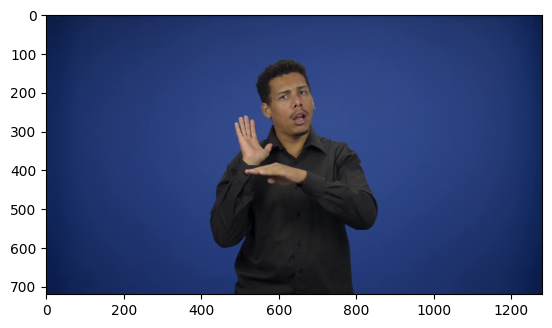

In [122]:
frame = viz.get_frame(20, original_video_path)
plt.imshow(frame)

### Landmarks Preprocessing

In [123]:
frame_index = 10

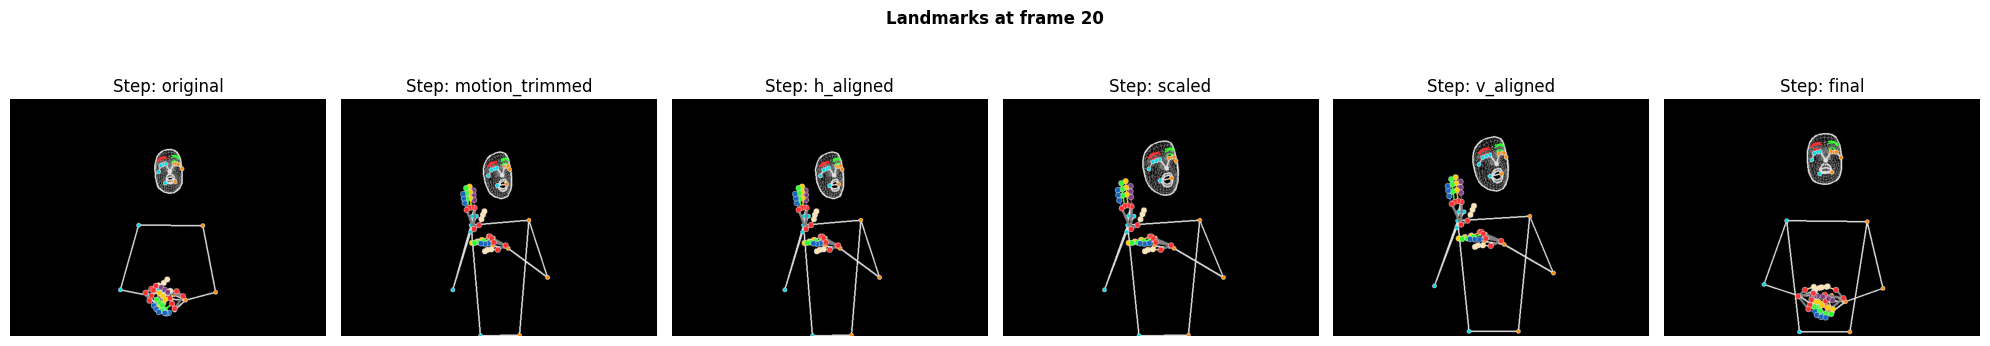

In [124]:
# subplots
fig, axs = plt.subplots(1, len(steps), figsize=(20, 4))
fig.suptitle("Landmarks at frame 20", fontweight="bold")


for step, ax in zip(steps, axs.flatten()):
    landmarks_path = os.path.join(
        path_to_root,
        "data",
        "interim",
        "Debug",
        "landmarks", metadata_row["filename"].split(".")[0] + f"_{step}.npy")
    landmarks = np.load(landmarks_path, allow_pickle=True)
    drawn_frame = mph.draw_landmarks_on_frame(np.zeros((480,640,3), dtype=np.uint8), landmarks[frame_index])
    ax.imshow(drawn_frame[:,:,::-1])
    ax.set_title(f"Step: {step}")
    ax.axis('off')
plt.tight_layout()
plt.show()

### Video Preprocessing

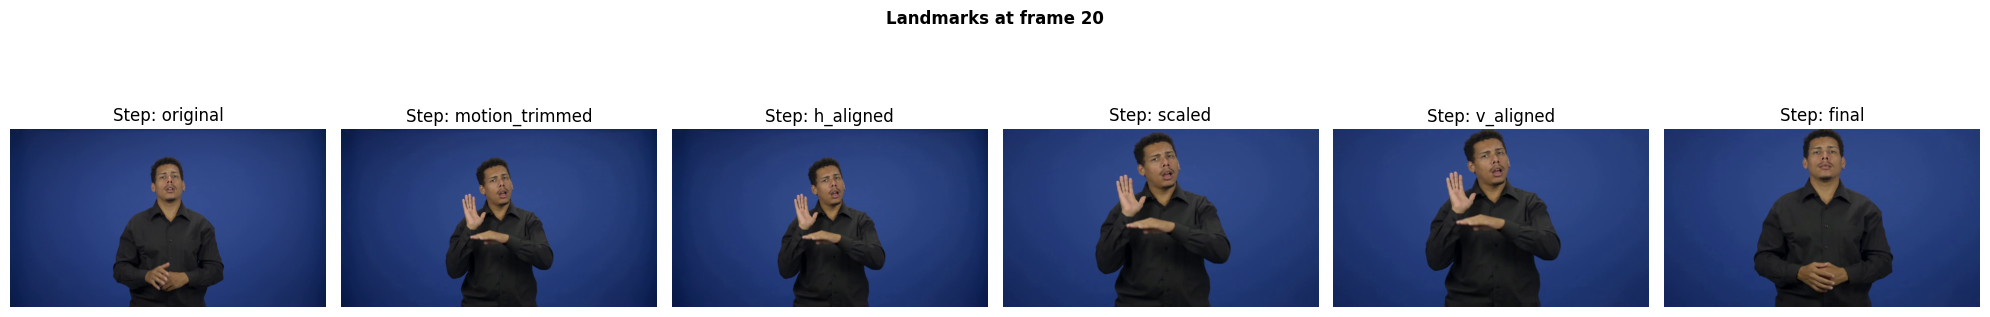

In [125]:
# subplots
fig, axs = plt.subplots(1, len(steps), figsize=(20, 4))
fig.suptitle("Landmarks at frame 20", fontweight="bold")


for step, ax in zip(steps, axs.flatten()):
    video_path = os.path.join(
        path_to_root,
        "data",
        "interim",
        "Debug",
        "videos", metadata_row["filename"].split(".")[0] + f"_{step}.mp4")
    frame = viz.get_frame(frame_index, video_path)
    ax.imshow(frame)
    ax.set_title(f"Step: {step}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## Multiple Videos

This section uses a sample of 6 videos from the dataset to show:
- the video analysis steps applied to multiple videos
- the preprocessing steps applied to multiple videos
- the orignal and preprocessed videos of the 6 samples for comparison


In [81]:
sample_metadata = metadata[metadata.label == "ajudar"].copy()
sample_metadata

,filename,label,data_source,frame_count,fps,duration_sec,width,height
0,ajudar_ne_1.mp4,ajudar,ne,44,12.00000,3.666667,240,176
1,ajudar_sb_2.mp4,ajudar,sb,79,29.97003,2.635967,1280,720
2,ajudar_uf_3.mp4,ajudar,uf,115,29.97003,3.837167,480,270
3,ajudar_vl_4.mp4,ajudar,vl,141,29.97003,4.704700,1920,1080
4,ajudar_vl_5.mp4,ajudar,vl,289,29.97003,9.642967,1920,1080
5,ajudar_vl_6.mp4,ajudar,vl,310,60.00000,5.166667,1920,1080


### Video Analyze

In [82]:
for i, metadata_row in sample_metadata.iterrows():
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    analyzer = VideoAnalyzer(
        metadata_row,
        timestamp,
        path_to_root,
        verbose=False,
        motion_detection_version=motion_version,
        pose_detection_version=pose_version
    )
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

    motion_data = analyzer.motion_detect()
    motion_result = analyzer.motion_analyze()

    pose_data = analyzer.pose_detect()
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    pose_result = analyzer.pose_analyze()
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

    analyzer.save_analysis_info()

window_duration: 0.2 seconds, at 12.0 fps = 2 frame window_size
No pose estimation results found for ajudar_ne_1.mp4 in versionA
Running pose estimation on /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_ne_1.mp4


W0000 00:00:1743856639.144860   61579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856639.188724   61579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856639.193816   61581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856639.193885   61580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856639.200019   61582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856639.218575   61577 landmark_projection_calculator.cc:186] Using NORM_RE

Saved pose estimation results to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA
window_duration: 0.2 seconds, at 29.97002997002997 fps = 5 frame window_size
No pose estimation results found for ajudar_sb_2.mp4 in versionA
Running pose estimation on /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_sb_2.mp4


W0000 00:00:1743856641.209446   61605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856641.228162   61605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856641.230481   61607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856641.230627   61605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856641.231081   61610 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856641.242134   61605 inference_feedback_manager.cc:114] Feedback manager 

Saved pose estimation results to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA
window_duration: 0.2 seconds, at 29.97002997002997 fps = 5 frame window_size
No pose estimation results found for ajudar_uf_3.mp4 in versionA
Running pose estimation on /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_uf_3.mp4


W0000 00:00:1743856644.904278   61643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856644.921936   61643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856644.925179   61645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856644.925333   61643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856644.925202   61648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856644.937773   61645 inference_feedback_manager.cc:114] Feedback manager 

Saved pose estimation results to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA
window_duration: 0.2 seconds, at 29.97002997002997 fps = 5 frame window_size
No pose estimation results found for ajudar_vl_4.mp4 in versionA
Running pose estimation on /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_vl_4.mp4


W0000 00:00:1743856649.212930   61683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856649.236922   61683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856649.239021   61687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856649.239739   61686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856649.240291   61683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856649.250507   61687 inference_feedback_manager.cc:114] Feedback manager 

Saved pose estimation results to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA
window_duration: 0.2 seconds, at 29.97002997002997 fps = 5 frame window_size
No pose estimation results found for ajudar_vl_5.mp4 in versionA
Running pose estimation on /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_vl_5.mp4


W0000 00:00:1743856656.510866   61734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856656.528266   61734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856656.530126   61731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856656.530670   61732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856656.530844   61734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856656.542232   61737 inference_feedback_manager.cc:114] Feedback manager 

Saved pose estimation results to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA
window_duration: 0.2 seconds, at 60.0 fps = 12 frame window_size
No pose estimation results found for ajudar_vl_6.mp4 in versionA
Running pose estimation on /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_vl_6.mp4


W0000 00:00:1743856668.520801   61790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856668.539257   61790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856668.541415   61789 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856668.541769   61792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856668.542227   61790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856668.553072   61789 inference_feedback_manager.cc:114] Feedback manager 

Saved pose estimation results to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA


W0000 00:00:1743856681.207868   61855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856681.233014   61855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856681.234749   61858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856681.235461   61854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856681.235533   61859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743856681.247836   61860 inference_feedback_manager.cc:114] Feedback manager 

### Preprocess

In [9]:
sample_metadata[4:]

,filename,label,data_source,frame_count,fps,duration_sec,width,height
4,ajudar_vl_5.mp4,ajudar,vl,289,29.97003,9.642967,1920,1080
5,ajudar_vl_6.mp4,ajudar,vl,310,60.00000,5.166667,1920,1080


In [83]:
for i, metadata_row in sample_metadata.iterrows():
    
    analysis_info_path = os.path.join(
        path_to_root, 
        "data", 
        "interim", 
        "Analysis", 
        f"{timestamp}_motion{motion_version}_pose{pose_version}", 
        metadata_row["filename"].split(".")[0] + "_analysis_info.json"
    )
    
    with open(analysis_info_path) as f:
        analysis_info = json.load(f)
    
    preprocessing_params = get_processing_params(analysis_info)

    preprocessor = Preprocessor(
        metadata_row,
        preprocessing_params,
        path_to_root,
        preprocess_version='v2',
        verbose=True,
        save_intermediate=True,
    )

    preprocessor.preprocess_video()
    
    # Clear memory before processing landmarks
    import gc
    gc.collect()
    
    # Process landmarks
    preprocessor.preprocess_landmarks()
    
    # Clear memory before next iteration
    del preprocessor
    del preprocessing_params
    del analysis_info
    gc.collect()

Initialized Preprocessor for ajudar_ne_1.mp4
Naming this preprocessing version: v2
Preprocessing video: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/raw/combined/videos/ajudar_ne_1.mp4
>> Saved original video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos/ajudar_ne_1_original.mp4
Loaded 44 frames from video
Trimmed video from 44 frames to 32 frames
Frame range: 7 to 38
>> Saved intermediate motion_trimmed video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos/ajudar_ne_1_motion_trimmed.mp4

Horizontally aligned frames with offset 0.019842283427715303, shifted 5 pixels right
Filled empty space with edge colors from the original frame
>> Saved intermediate h_aligned video to /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/Debug/videos/ajudar_ne_1_h_aligned.mp4

Scaled frames with factors: x=0.7841800340564054, y=0.9658650037056522
Using edge colors to

### Vizualisation

In [35]:
import vizualisation as viz
mph = viz.MediaPipeHolistic()

W0000 00:00:1743844851.590752   43988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743844851.635902   43988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743844851.646145   43984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743844851.650532   43982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743844851.676611   43988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743844851.815626   43984 inference_feedback_manager.cc:114] Feedback manager 

In [67]:
preprocessed_metadata = pd.read_csv(os.path.join(
    path_to_root,
    "data",
    "preprocessed",
    "preprocessed_metadata_v2.csv"))
sample_preprocessed_metadata = preprocessed_metadata[preprocessed_metadata.label == "ajudar"]
sample_preprocessed_metadata

,filename,label,data_source,original_fps,original_width,original_height,original_frame_count,original_duration_sec,original_start_frame,original_end_frame,preprocessed_frame_count,preprocessed_duration_sec,preprocessed_start_frame,preprocessed_end_frame,horizontal_offset,vertical_offset,x_scale_factor,y_scale_factor,preprocess_version
0,ajudar_ne_1.mp4,ajudar,ne,12.00000,240,176,44,3.666667,7,38,72,6,20,51,0.019842,-0.006084,0.784180,0.965865,v2
1,ajudar_sb_2.mp4,ajudar,sb,29.97003,1280,720,79,2.635967,8,71,179,6,57,120,0.003489,-0.018081,1.254403,1.168761,v2
2,ajudar_uf_3.mp4,ajudar,uf,29.97003,480,270,115,3.837167,25,105,179,6,49,129,0.008005,-0.081231,1.233224,1.172439,v2
3,ajudar_vl_4.mp4,ajudar,vl,29.97003,1920,1080,141,4.704700,12,138,179,6,26,152,-0.003169,0.058254,1.220824,1.018915,v2
4,ajudar_vl_5.mp4,ajudar,vl,29.97003,1920,1080,289,9.642967,4,287,179,6,56,234,0.000964,-0.035512,1.011627,0.996811,v2
5,ajudar_vl_6.mp4,ajudar,vl,60.00000,1920,1080,310,5.166667,7,308,360,6,29,330,-0.013912,0.024258,0.968659,1.045554,v2


In [68]:
ref_points = {
'face_horizontal_offset': 0.5,
'face_vertical_offset': 0.275,
'face_width': 0.11,
'face_height': 0.23,
'shoulders_horizontal_offset': 0.5,
'shoulders_vertical_offset': 0.52,
'shoulders_width': 0.25,
}

In [85]:
frame_index = 10

### Preprocessed Landmarks 

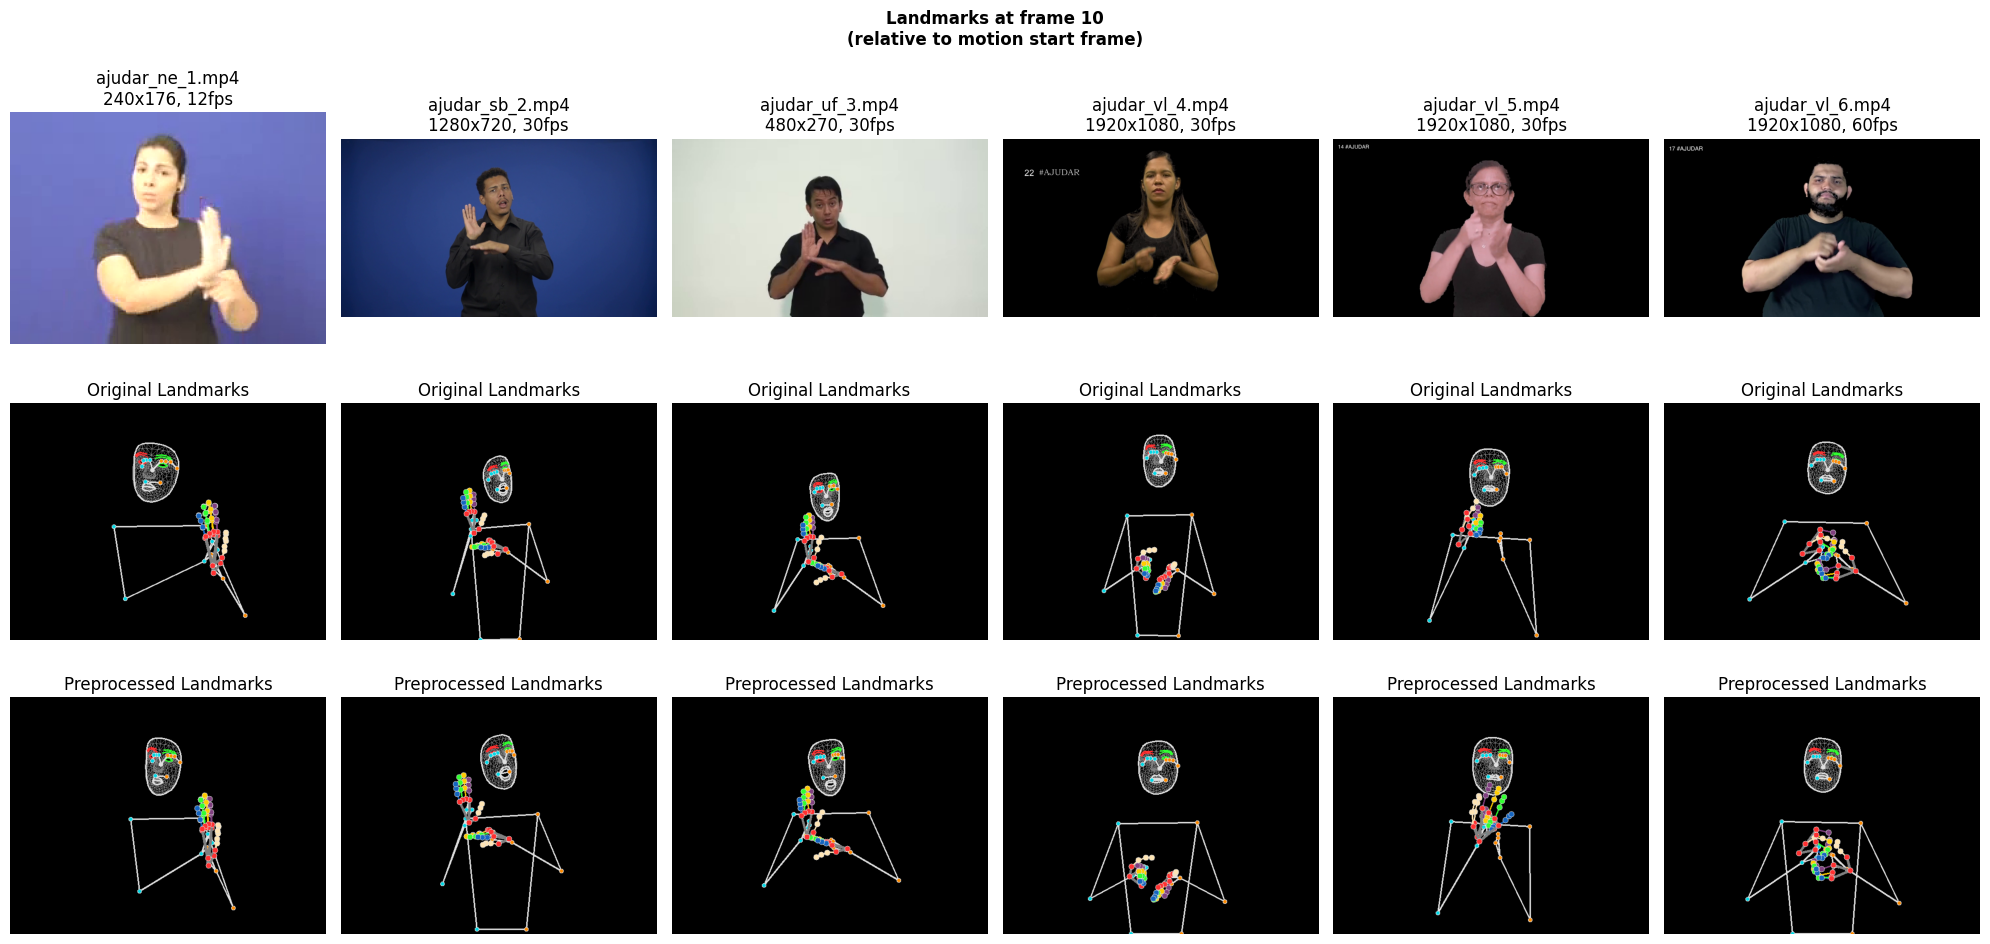

In [86]:
# subplots
fig, axs = plt.subplots(3, len(sample_preprocessed_metadata), figsize=(20, 10))
fig.suptitle(f"Landmarks at frame {frame_index}\n(relative to motion start frame)", fontweight="bold")


for (i, row), ax in zip(sample_preprocessed_metadata.iterrows(), axs.T):
    debug_landmarks_path = os.path.join(
        path_to_root,
        "data",
        "interim",
        "Debug",
        "landmarks", row["filename"].split(".")[0])
    preprocessed_landmarks_path = os.path.join(
        path_to_root,
        "data",
        "preprocessed",
        "landmarks",
        "v2", row["filename"].split(".")[0])
    video_path = os.path.join(
        path_to_root,
        "data",
        "interim",
        "Debug",
        "videos", row["filename"].split(".")[0] + f"_original.mp4")

    original_start_frame = row['original_start_frame']
    preprocessed_start_frame = row['preprocessed_start_frame']
    frame = viz.get_frame(original_start_frame+frame_index, video_path)

    original_landmarks_path = debug_landmarks_path + "_original.npy"
    preprocessed_landmarks_path = preprocessed_landmarks_path + ".npy"

    original_landmarks = np.load(original_landmarks_path, allow_pickle=True)
    final_landmarks = np.load(preprocessed_landmarks_path, allow_pickle=True)

    original_drawn_frame = mph.draw_landmarks_on_frame(np.zeros((480,640,3), dtype=np.uint8), original_landmarks[original_start_frame+frame_index])
    final_drawn_frame = mph.draw_landmarks_on_frame(np.zeros((480,640,3), dtype=np.uint8), final_landmarks[preprocessed_start_frame+frame_index])

    ax[0].imshow(frame)
    ax[1].imshow(original_drawn_frame[:,:,::-1])
    ax[2].imshow(final_drawn_frame[:,:,::-1])
    ax[0].set_title(f"{row['filename']}\n{row['original_width']}x{row['original_height']}, {int(round(row['original_fps']))}fps")
    ax[1].set_title(f"Original Landmarks")
    ax[2].set_title(f"Preprocessed Landmarks")
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
plt.tight_layout()
plt.show()

### Preprocessed Videos

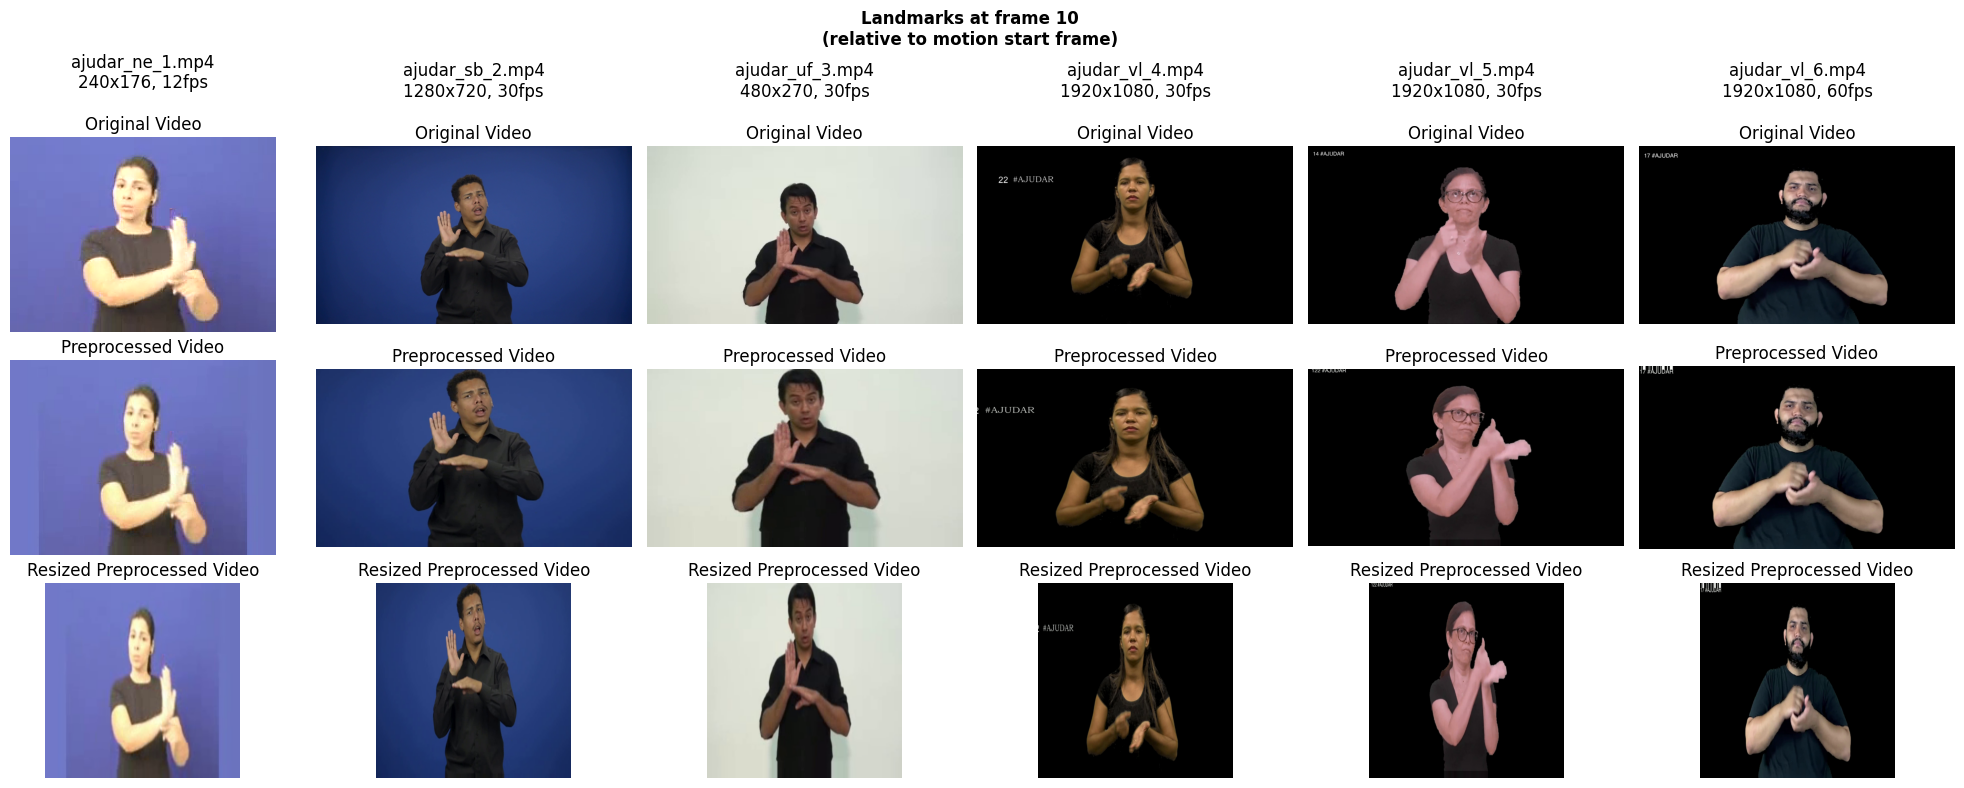

In [90]:
# subplots
fig, axs = plt.subplots(3, len(sample_preprocessed_metadata), figsize=(20, 8))
fig.suptitle(f"Landmarks at frame {frame_index}\n(relative to motion start frame)", fontweight="bold")


for (i, row), ax in zip(sample_preprocessed_metadata.iterrows(), axs.T):

    video_path = os.path.join(
        path_to_root,
        "data",
        "interim",
        "Debug",
        "videos", row["filename"].split(".")[0] + f"_original.mp4")
    processed_video_path = os.path.join(
        path_to_root,
        "data",
        "preprocessed",
        "videos",
        "v2",
        row["filename"])

    original_start_frame = row['original_start_frame']
    preprocessed_start_frame = row['preprocessed_start_frame']

    original_frame = viz.get_frame(frame_index + original_start_frame, video_path)
    processed_frame = viz.get_frame(frame_index + preprocessed_start_frame, processed_video_path)
    target_dims = (640, 640)
    resized_processed_frame = cv2.resize(processed_frame, target_dims)
    # drawn_processed_frame = viz.plot_key_landmarks(
    #     landmark_points=ref_points,
    #     frame=processed_frame,
    #     line_color=(0, 255, 0),
    #     line_width=2,
    #     axis_lines=True,
    # )

    ax[0].imshow(original_frame)
    ax[1].imshow(processed_frame)
    ax[2].imshow(resized_processed_frame)
    ax[0].set_title(f"{row['filename']}\n{row['original_width']}x{row['original_height']}, {int(round(row['original_fps']))}fps\n\nOriginal Video")
    ax[1].set_title(f"Preprocessed Video")
    ax[2].set_title(f"Resized Preprocessed Video")
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
plt.tight_layout()
plt.show()